Goal: basic dataset understanding – shapes, distributions, lengths, etc.

In [1]:
%load_ext autoreload
%autoreload 2

Cell 1 – imports and config path

In [9]:
import sys
from pathlib import Path
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yaml

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=INFO, 2=WARNING, 3=ERROR
# Robust project root resolver: works whether you launch Jupyter from root or /notebooks
def find_project_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / 'configs' / 'base.yaml').exists() and (p / 'src').exists():
            return p
    raise FileNotFoundError('Could not locate project root (expected configs/base.yaml and src/)')


PROJECT_ROOT = find_project_root(Path.cwd())

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data.load import load_yaml, load_all_sources, add_broad_category, load_category_mapping

CONFIG_PATH = PROJECT_ROOT / 'configs' / 'base.yaml'
print('PROJECT_ROOT:', PROJECT_ROOT)
print('CONFIG_PATH:', CONFIG_PATH)

PROJECT_ROOT: /home/spark/NUST/Semester 5/Data Mining/Project
CONFIG_PATH: /home/spark/NUST/Semester 5/Data Mining/Project/configs/base.yaml


Cell 2 – load config and data

In [10]:
cfg = load_yaml(CONFIG_PATH)
df = load_all_sources(cfg, root=PROJECT_ROOT)
df = add_broad_category(df, cfg, root=PROJECT_ROOT)

print(df.shape)
df.head()
print('Rows:', len(df))
print('Unique broad_category:', df['broad_category'].nunique() if 'broad_category' in df.columns else 'N/A')
print('Unique sources:', df['source'].nunique() if 'source' in df.columns else 'N/A')

INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/s

(40000, 8)
Rows: 40000
Unique broad_category: 8
Unique sources: 4


headline          0.0
description       0.0
categories        0.0
source            0.0
broad_category    0.0
dtype: float64

Cell 3 – quick info & missing values

In [11]:
df.info()

df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   headline        40000 non-null  object
 1   date            40000 non-null  object
 2   link            40000 non-null  object
 3   source          40000 non-null  object
 4   categories      40000 non-null  object
 5   description     40000 non-null  object
 6   __file__        40000 non-null  object
 7   broad_category  40000 non-null  object
dtypes: object(8)
memory usage: 2.4+ MB


headline          0
date              0
link              0
source            0
categories        0
description       0
__file__          0
broad_category    0
dtype: int64

Cell 4 – distribution of `source` and `broad_category`

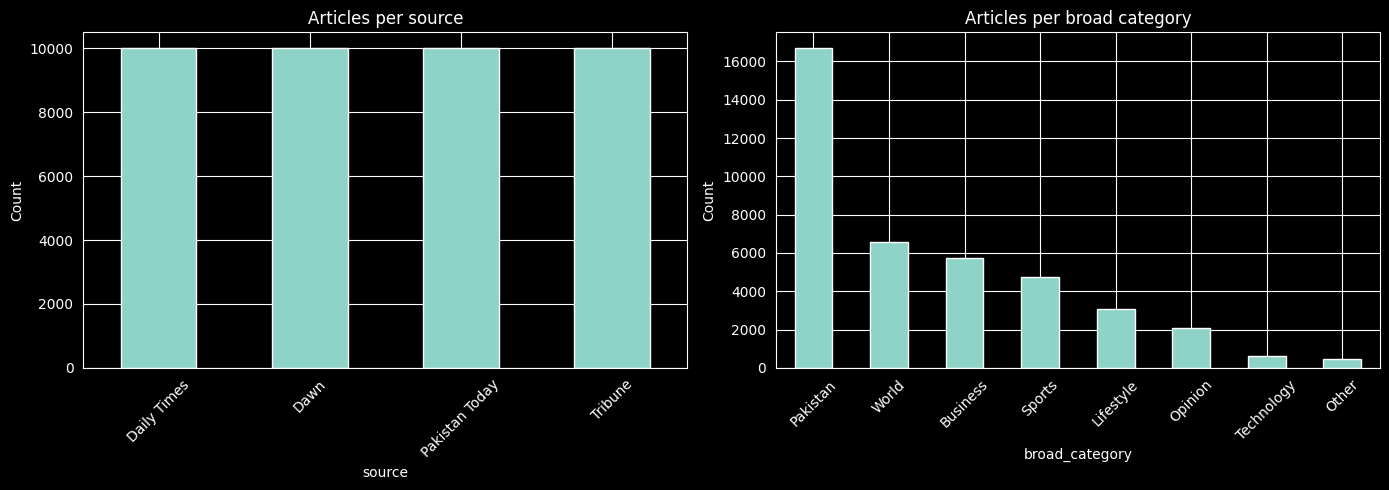

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['source'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Articles per source')
axes[0].set_ylabel('Count')

df['broad_category'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Articles per broad category')
axes[1].set_ylabel('Count')

axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()

plt.show()

Cell 5 – (source, broad_category) heatmap

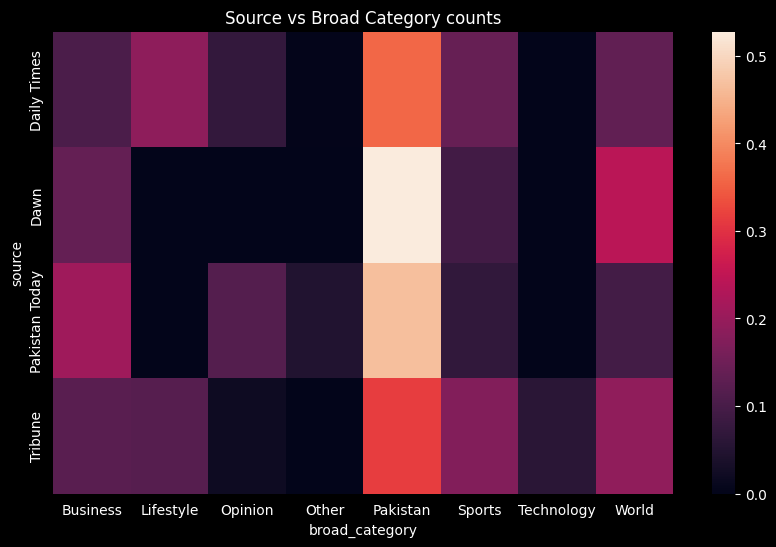

In [13]:
pivot = df.pivot_table(
    index='source',
    columns='broad_category',
    values='headline',
    aggfunc='count',
    fill_value=0,
)
pivot = pivot.div(pivot.sum(axis=1), axis=0)  # per-source proportions


plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=False, fmt='d')
plt.title('Source vs Broad Category counts')
plt.show()

Cell 6 – text length distributions

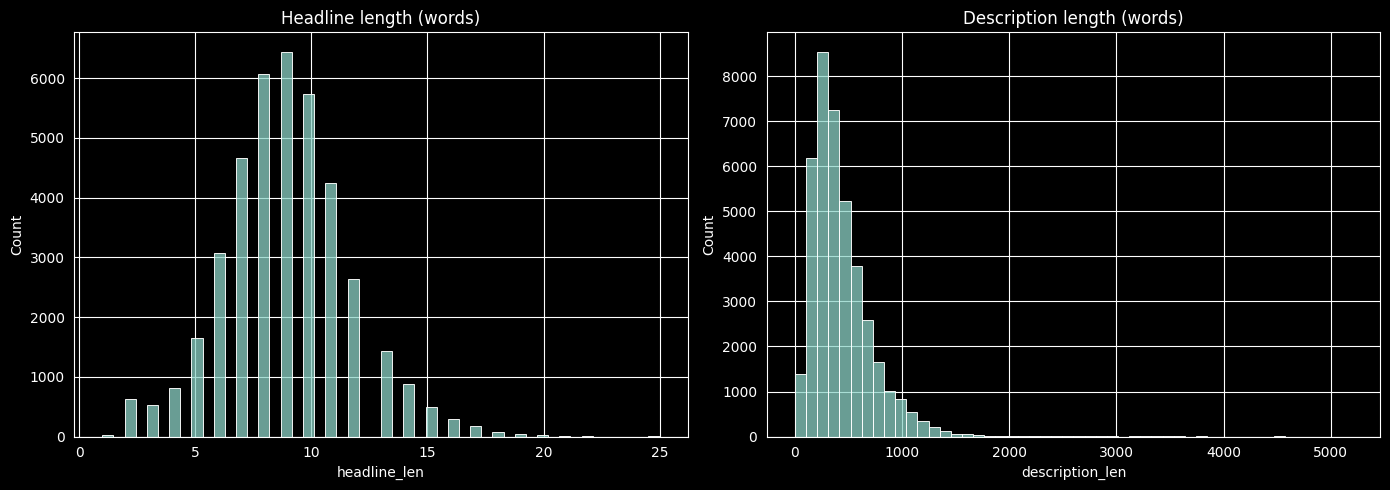

In [14]:
df['headline_len'] = df['headline'].fillna('').str.split().str.len()
df['description_len'] = df['description'].fillna('').str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['headline_len'], bins=50, ax=axes[0])
axes[0].set_title('Headline length (words)')

sns.histplot(df['description_len'], bins=50, ax=axes[1])
axes[1].set_title('Description length (words)')

plt.tight_layout()
plt.show()

Cell 7 – sample few rows per category

In [15]:
samples = df.groupby('broad_category').head(2)[
    ['broad_category', 'source', 'headline', 'description']
].copy()

samples['description'] = samples['description'].fillna('').str.slice(0, 250) + '...'
samples

,broad_category,source,headline,description
0,World,Daily Times,Virus hits entire Venezuelan family in Peru,The 14 members of the Hernandez family arrived...
1,Pakistan,Daily Times,EVMs being opposed to manipulate polls: Imran,Prime Minister Imran Khan Wednesday said manip...
2,Pakistan,Daily Times,Secretary Livestock wants timely delivery of v...,Secretary Livestock Capt (R) Saqib Zafar chair...
4,World,Daily Times,"South Africa government, private hospitals agr...",The South African government has agreed how mu...
5,Business,Daily Times,"Gold Rate In Pakistan Today, 25th November 2021",Gold Rate in Pakistan today on 25 November 202...
7,Sports,Daily Times,"Kyrgios, Halep storm into Wimbledon quarterfinals",Romania’s Simona Halep returns the ball to Spa...
8,Sports,Daily Times,PCB names 13 Balochistan CCA U19 squads for 50...,LAHORE: Pakistan Cricket Board on Monday annou...
13,Lifestyle,Daily Times,Javed Akhtar compares state of poverty in Paki...,Javed Akhtar has compared the poverty of India...
16,Opinion,Daily Times,Fires Across the Continents: Global Warming on...,It is time to wake up. We are facing the bigge...
18,Lifestyle,Daily Times,Ridley Scott’s ‘Raised By Wolves’ Is a Grim Bo...,Creating a post-apocalyptic story that feels g...
